# Calculation of detectable Gamma ray burst (GRB) event rate associated with Binary Neutron Star (BNS) mergers.

Analyst: [Hemanta Ph.](https://hemantaph.notion.site/Hemanta-Ph-b4c52e857d424c0db2a68f4e63d6097f), Anupreeta More, Otto Hannuksela.

Notes:

* This is without considering a particular detectors' sensitivity, but rather a general calculation of the rate of detectable GRBs based of viewing angle and luminosity distance. I have considered the inclination angle gravitational waves same as the viewing angle wrt GRB jet axis.

* It involves constructing Pdet (detection probability) function based off luminosity function.

* For BNS source redshift and mass distribution, refer [here](https://ler.readthedocs.io/en/latest/GW_events.html).

* For lens and image properties, refer [here](https://ler.readthedocs.io/en/latest/Lensed_events.html).

* Both SWIFT and FERMI detectors are considered.

* All analysis will be limited to redshift $z\in [0,5]$.

### Combined plot of viewing angle vs redshift for both conditions (left: Codition1, right: Condition2).

<p align="center">
  <img src="./combined final.png" alt="Your Logo" width="200%" style="margin: 0; padding: 0;">
</p>

## Equations (GRB)

* Ref: [Howell et. al. (2019)](https://arxiv.org/pdf/1811.09168)

* The luminosity function of GRBs is given by:

$$L(\theta_{V})=L_{c}\text{exp}(-\frac{\theta^{2}}{2\theta_{c}^{2}})$$

* Here, $L(\theta_{V})$ is the luminosity at viewing angle $\theta_{V}$, $L_{c}$ is the luminosity at the jet axis, $\theta$ is the viewing angle, and $\theta_{c}$ is the core angle of the jet.

* The paper gives: $\theta_{c} = 5$ degree.

* I will infer the probability of detection from the above equations.

$$P_{det}(\theta,D_L) = \left\{ 
  \begin{array}{ c l }
    1 & \text{if } \theta \le 5 \text{ deg and } D_L \le 46652 \text{ Mpc } (z\sim 5) \\
    1 & \text{if } \frac{\text{a}}{4\pi D_L^2} \text{exp}(-\frac{\theta^{2}}{2\times 21.2^2}) \ge 1 \\
    0 & \text{otherwise}
  \end{array}
\right.$$

* Coefficients a is solved by considering conditions 2 below,
  1. If angle <= 5 deg, distance <= distance_cut, then $P_{det}$ = 1.
  2. pdet=1, If angle=21.2 deg (at distance=40Mpc). This is by considering the GRB from GW170817 would have been difficult to detect if viewing angle>21.2 deg (at distance=40Mpc) or distance>40 Mpc (at angle=21.2 deg).

In [1]:
# calling the necessary libraries
from ler.rates import LeR
import numpy as np
# interpolate
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from ler.utils import get_param_from_json

Setting multiprocessing start method to 'fork'


## Probability of detection of GRBs

### Finding the coefficients

In [2]:
import numpy as np
from scipy.optimize import fsolve

# to find coefficient a
# consider: pdet = 1, If angle = 21.2 deg (at distance=40). 
def equation(a):
    angle = 21.2
    distance = 40
    return a/(4*np.pi*distance**2) * np.exp(-0.5*(angle/5)**2) - 1

a_guess = 10000

# Solve the equation
a_solution = fsolve(equation, a_guess)

print(f"a = {a_solution[0]}")

a = 161107621.34601912


### Function to calculate the probability of detection

In [3]:
# Find distance_cut
# convert redshift to luminoisty distance
import astropy.units as u
from astropy.cosmology import LambdaCDM
cosmo = LambdaCDM(H0=70, Om0=0.3, Ode0=0.7)
# let's assume z = 5 is the distance cut
z = 5
d_L = cosmo.luminosity_distance(z)
print(f"d_L = {d_L}")

d_L = 46652.22297277721 Mpc


In [4]:
class GRB:
    def __init__(self,
    z_min = 0, # minimum redshift
    z_max = 10, # maximum redshift 
    core_angle = 5, # core angle in degrees
    distance_cut = 46652.22297277721, # distance cut in Mpc for z=5
    cosmo = LambdaCDM(H0=70, Om0=0.3, Ode0=0.7), # cosmology
    ):
        self.core_angle = core_angle
        self.distance_cut = distance_cut
        self.cosmo = cosmo
        self.coefficient = self.coefficient_finder()

        # interpolate and find luminosity distance to redshift conversion
        z = np.geomspace(z_min+0.0001, z_max, 10000)
        d_L = cosmo.luminosity_distance(z).value
        self.z_to_dl = interp1d(z, d_L, kind='cubic', fill_value='extrapolate')
        self.dl_to_z = interp1d(d_L, z, kind='cubic', fill_value='extrapolate')

    def coefficient_finder(self, a_guess = 10000):
        """
        Function to find the coefficient 'a' in the GRB pdet model.
        pdet = a/(4*np.pi*distance**2) * np.exp(-0.5*(angle/5)**2){2\times 21.2^2})
        pdet = 1, If angle = 21.2 deg (at distance=40).

        Parameters
        ----------
        a_guess : float
            Initial guess for the coefficient 'a'
            default is 10000

        Returns
        -------
        float
            Coefficient 'a' in the GRB pdet model
        """
        def equation(a):
            # wrt to GW170817
            angle = 21.2
            distance = 40
            return a/(4*np.pi*distance**2) * np.exp(-0.5*(angle/5)**2) - 1

        a_solution = fsolve(equation, a_guess)
        return a_solution[0]
    
    def pdet_grb(self, angle, distance, distance_cut=None, duty_cycle=0.5, mask_duty_cycle=True, bool=True, pdet_cut=1.):
        """
        Function to calculate the probability of detection for a given angle and distance (Mpc) for GRB. 

        Parameters
        ----------
        angle : numpy.ndarray
            Angle between the GRB jet and viewing angle in (rad)
        distance : numpy.ndarray
            Distance between the GRB source and the satellite in (Mpc)
        distance_cut : float
            Core angular size of the GRB jet in (rad)
            default is 25422.742 Mpc
        duty_cycle : float
            Duty cycle of detector(s)
            default is 0.5 (50%: for Fermi-GBM and Swift-BAT combined)
        bool : bool
            if True, return absolute value of pdet
            if False, return the pdet value as boolean (with duty cycle applied)

        Returns
        -------
        numpy.ndarray
            Probability of detection for a given angle and distance
        """

        a = self.coefficient
        jet_angle_cut = self.core_angle
        if distance_cut is None:
            distance_cut = self.distance_cut

        # make sure that the input data is a numpy array
        angle, distance = np.array([angle]).reshape(-1), np.array([distance]).reshape(-1)

        # angle should be less than 90 or equal to 90
        if len(angle[angle > 90]) > 0:
            angle[angle > 90] = angle[angle > 90]%90

        if bool:
            # calculate the probability of detection, absolute value
            pdet = abs(a/(4*np.pi*distance**2) * np.exp(-0.5*(angle/jet_angle_cut)**2))

            # find idx of angle <= jet_angle_cut and distance <= distance_cut
            idx = (angle <= jet_angle_cut) & (distance <= distance_cut)
            # apply the condition, condition 1 from docstring
            pdet[idx] = 1

            # apply the duty cycle
            if mask_duty_cycle:
                # sample random numbers from 0 to 1 and check if it is less than the duty cycle
                num_ = np.random.rand(len(angle))
                mask_duty_cycle = num_ > duty_cycle
                pdet[mask_duty_cycle] = 0

            # return the pdet as boolean
            return (pdet>=pdet_cut).astype(int)
        else:
            # return the probability of detection (absolute value)
            return abs(a/(4*np.pi*distance**2) * np.exp(-0.5*(angle/jet_angle_cut)**2))
    
    def pdet_calculator(self, gw_param_dict, duty_cycle=0.5, mask_duty_cycle=True, bool=True, pdet_cut=1.):
        """
        Pdet calculator for GRB. The  inputs and outputs are are compatible with ler package.

        Parameters
        ----------
        gw_param_dict : dict
            dictionary containing the parameters for the GW event
        duty_cycle : float
            Duty cycle of detector(s)
            default is 0.5 (50%: for Fermi-GBM and Swift-BAT combined)
        mask_duty_cycle : bool
            if True, apply the duty cycle
            default is True
        bool : bool
            if True, return absolute value of pdet
            if False, return the pdet value as boolean (with duty cycle applied)

        Returns
        -------
        dict
            dictionary containing the probability of detection for the given GW event
        """

        # get the angle and distance from the dictionary
        angle = np.degrees(gw_param_dict['theta_jn'])
        if 'luminosity_distance' in gw_param_dict:
            distance = gw_param_dict['luminosity_distance']
        elif 'effective_luminosity_distance' in gw_param_dict:
            distance = gw_param_dict['effective_luminosity_distance']

        # calculate the probability of detection
        pdet = self.pdet_grb(angle, distance, duty_cycle=duty_cycle, mask_duty_cycle=mask_duty_cycle, bool=bool, pdet_cut=pdet_cut)
        pdet_net_dict = dict(pdet_net=pdet)

        # return the pdet
        return pdet_net_dict

In [5]:
# class initialization
grb = GRB()

In [6]:
# test the pdet_grb function
angle = np.array([1, 1, 20, 90])
distance = np.array([46652, 46653, 40, 40])
print(grb.pdet_grb(angle, distance, mask_duty_cycle=False, bool=True))

[1 0 1 0]


In [7]:
# test the pdet_calculator function
gw_param_dict = {'theta_jn': np.radians(np.array([1, 21.2, 90])), 'luminosity_distance': np.array([2500, 40, 40])}
print(grb.pdet_calculator(gw_param_dict, mask_duty_cycle=False, bool=True))

{'pdet_net': array([1, 1, 0])}


### Plot detection and non-detection regions

In [8]:
# generate random data
angle = np.random.uniform(0, 30, 5000)
log10_distance = np.random.uniform(0, 5, 5000)
distance = 10**log10_distance
redshift = grb.dl_to_z(distance)

pdet = grb.pdet_grb(angle, distance, mask_duty_cycle=False, bool=True)

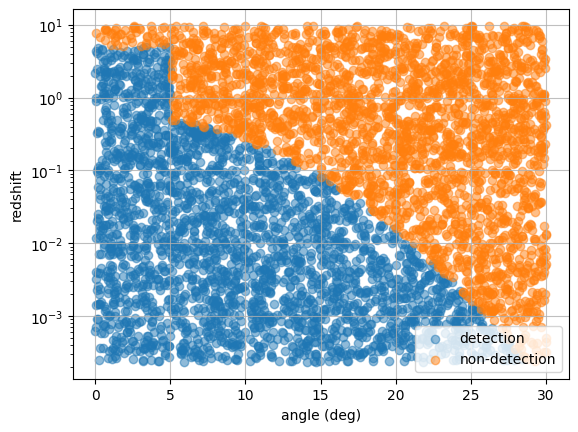

In [9]:
# blue: detection, red: non-detection
plt.scatter(angle[pdet==1], redshift[pdet==1], c='C0', label="detection", alpha=0.5)
plt.scatter(angle[pdet==0], redshift[pdet==0], c='C1', label="non-detection", alpha=0.5)

# draw a horizontal line for GW170817, 40Mpc
# plt.hlines(y=grb.dl_to_z(40), xmin=min(angle)-1, xmax=max(angle)+1, colors='C3', linestyles='solid', label='40Mpc, GW170817')

plt.xlabel("angle (deg)")
plt.ylabel("redshift")
plt.yscale("log")
plt.legend()
plt.grid(alpha=0.8)
plt.show()

## Rate calculation of GRB with LeR

All the necessary functions and parameters are defined below.

**Source related:**
* source frame mass: m1 and m2 sample from [double Gaussian](https://ler.readthedocs.io/en/latest/GW_events.html#BNS-mass-distribution:-Bimodal-Gaussian-Model) model lim[1,2.3]Mo
* Geocent time period: uniform prior, 1 year GPS: {'min_': 1238166018, 'max_': 1269702018}
* Redshift: 0 to 5, uniform, 
  * this follows [merger rate density distribution](https://ler.readthedocs.io/en/latest/GW_events.html#Merger-Rate-Density-Formula)
* ra:  sampler_uniform {'min_': 0.0, 'max_': 6.283185307179586}
* dec:  sampler_cosine [-np.pi/2, np.pi/2]
* phase : sampler_uniform {'min_': 0.0, 'max_': 6.283185307179586}
* psi: sampler_uniform {'min_': 0.0, 'max_': 3.141592653589793}
* theta_jn: sampler_uniform {'min_': 0.0, 'max_': 3.141592653589793}

**Lens related**
* Optical depth: SIE , 
  * so zs for lensed are rejection sampled with optical depth. 
* Lens redshifts: SDSS catalogue (0 to zs), the function of zs Reenske et al. 2021 ( eqnC13). [`ler` function](https://github.com/hemantaph/ler/blob/bce3330638a13ee0883d19633abb17b98791c901/ler/lens_galaxy_population/jit_functions.py#L218)
* Velocity dispersion: gengamma, Haris et al 2018, a=2.32 / 2.67, c=2.67, vd_min=0., vd_max=600.(https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.gengamma.html) use in Haris et al upto zs~1.5 (with a=2.32 / 2.67, c=2.67)
* Axis ratio: Raleigh (with Velocity dispersion dependence) {'q_min': 0.2, 'q_max': 1.0}
* axis_rotation_angle : uniform {'phi_min': 0.0, 'phi_max': 6.283185307179586}
* shear: normal {'scale': 0.05}
* density_profile_slope: normal {'mean': 2.0, 'std': 0.2}

**Image related:**
* Strong lensing condition: num_images>=2
* Lens equation solver: EPL+Shear, `lenstronomy`
* Source position: sample within caustic,  Ewoud et. al. 2022

## MEDIAN

In [11]:
ler = LeR(
    npool=8,
    verbose=False,
    z_max=10,
    pdet_finder=grb.pdet_calculator,
    source_priors= {'merger_rate_density': 'merger_rate_density_bbh_popI_II_oguri2018'},
    source_priors_params= {'merger_rate_density': {'R0': 10.55e-08, 'b2': 1.6, 'b3': 2.0, 'b4': 30}},
    event_type='BNS',
    mtot_max=51,
    psds={'L1':'../rates_o4/o4_psd.txt', 'H1':'../rates_o4/o4_psd.txt'},
    snr_type="interpolation",
)

### Unlensed events

In [14]:
unlensed_param_detectable = ler.selecting_n_unlensed_detectable_events(
    size=400000,
    batch_size=200000,
    resume=True,
    trim_to_size=False,
    detectability_condition="pdet",
    output_jsonfile="n_unlensed_params_detectable_grb_median.json",
    meta_data_file="meta_unlensed_grb_median.json",
)

collected number of detectable events =  136434
given detectability_condition == 'pdet'
collected number of detectable events =  140713
total number of events =  6800000
total rate (yr^-1): 9456.19204050512
given detectability_condition == 'pdet'
collected number of detectable events =  144835
total number of events =  7000000
total rate (yr^-1): 9455.107208561909
given detectability_condition == 'pdet'
collected number of detectable events =  148900
total number of events =  7200000
total rate (yr^-1): 9450.464938535495
given detectability_condition == 'pdet'
collected number of detectable events =  153065
total number of events =  7400000
total rate (yr^-1): 9452.24891899328
given detectability_condition == 'pdet'
collected number of detectable events =  157236
total number of events =  7600000
total rate (yr^-1): 9454.299774260438
given detectability_condition == 'pdet'
collected number of detectable events =  161367
total number of events =  7800000
total rate (yr^-1): 9453.9020038

KeyboardInterrupt: 

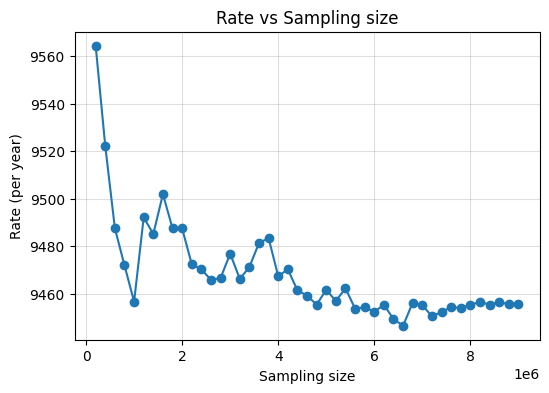

In [20]:
# getting data from json
meta_data= get_param_from_json("ler_data/meta_unlensed_grb_median.json")

# plot the rate vs sampling size
plt.figure(figsize=(6,4))
plt.plot(meta_data['events_total'], meta_data['total_rate'], 'o-')
plt.xlabel('Sampling size')
plt.ylabel('Rate (per year)')
plt.title('Rate vs Sampling size')
plt.grid(alpha=0.4)
plt.show()

In [21]:
# select only events after sampling size of 
idx = np.where(meta_data['events_total'] > 8e6)[0]
# take average 
grb_rate_unlensed_median = np.mean(meta_data['total_rate'][idx])
print('Unlensed GRB Rate (per year) =', grb_rate_unlensed_median)

Unlensed GRB Rate (per year) = 9455.892730832371


### Lensed events

In [17]:
lensed_param_detectable = ler.selecting_n_lensed_detectable_events(
    size=100000,
    batch_size=200000,
    # snr_threshold=[8.0,8.0],
    # num_img=[1,1],
    resume=True,
    trim_to_size=True,
    detectability_condition="pdet",
    output_jsonfile="n_lensed_params_detectable_grb_median.json",
    meta_data_file="meta_lensed_grb_median.json",
)

collected number of detectable events =  0


100%|█████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 69.27it/s]


given detectability_condition == pdet
collected number of detectable events =  1741
total number of events =  200000
total rate (yr^-1): 8.722403264202525


100%|█████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 76.12it/s]


given detectability_condition == pdet
collected number of detectable events =  3479
total number of events =  400000
total rate (yr^-1): 8.714888270005911


100%|█████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 44.79it/s]


given detectability_condition == pdet
collected number of detectable events =  5154
total number of events =  600000
total rate (yr^-1): 8.607173353187786


100%|█████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 47.32it/s]


given detectability_condition == pdet
collected number of detectable events =  6844
total number of events =  800000
total rate (yr^-1): 8.572103380270258


100%|█████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 23.31it/s]


given detectability_condition == pdet
collected number of detectable events =  8586
total number of events =  1000000
total rate (yr^-1): 8.603165356282927


  1%|▌                                                      | 2258/200000 [00:00<00:51, 3830.88it/s]


KeyboardInterrupt: 

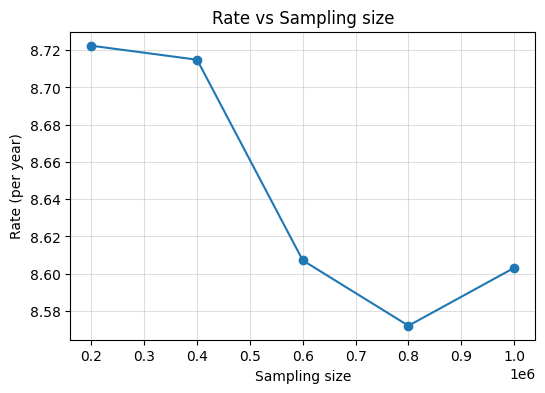

In [23]:
# getting data from json
meta_data= get_param_from_json("ler_data/meta_lensed_grb_median.json")

# plot the rate vs sampling size
plt.figure(figsize=(6,4))
plt.plot(meta_data['events_total'], meta_data['total_rate'], 'o-')
plt.xlabel('Sampling size')
plt.ylabel('Rate (per year)')
plt.title('Rate vs Sampling size')
plt.grid(alpha=0.4)
plt.show()

In [24]:
# select only events after sampling size of 
idx = np.where(meta_data['events_total'] > 0.5e6)[0]
# take average 
grb_rate_lensed_median = np.mean(meta_data['total_rate'][idx])
print('Lensed GRB Rate (per year) =', grb_rate_lensed_median)

Lensed GRB Rate (per year) = 8.594147363246991


In [25]:
grb_rate_unlensed_median/grb_rate_lensed_median, grb_rate_unlensed_median, grb_rate_lensed_median

(1100.2711881891446, 9455.892730832371, 8.594147363246991)

## LOW

In [29]:
ler = LeR(
    npool=8,
    verbose=False,
    z_max=10,
    pdet_finder=grb.pdet_calculator,
    source_priors= {'merger_rate_density': 'merger_rate_density_bbh_popI_II_oguri2018'},
    source_priors_params= {'merger_rate_density': {'R0': (10.55-8.39)*1e-08, 'b2': 1.6, 'b3': 2.0, 'b4': 30}},
    event_type='BNS',
    mtot_max=51,
    psds={'L1':'../rates_o4/o4_psd.txt', 'H1':'../rates_o4/o4_psd.txt'},
    snr_type="interpolation",
)

In [30]:
unlensed_param_detectable = ler.selecting_n_unlensed_detectable_events(
    size=400000,
    batch_size=200000,
    resume=True,
    trim_to_size=False,
    detectability_condition="pdet",
    output_jsonfile="n_unlensed_params_detectable_grb_low.json",
    meta_data_file="meta_unlensed_grb_low.json",
)

collected number of detectable events =  0
given detectability_condition == 'pdet'
collected number of detectable events =  4247
total number of events =  200000
total rate (yr^-1): 1986.7559884182897
given detectability_condition == 'pdet'
collected number of detectable events =  8314
total number of events =  400000
total rate (yr^-1): 1944.6537894642877
given detectability_condition == 'pdet'
collected number of detectable events =  12502
total number of events =  600000
total rate (yr^-1): 1949.4877456404881
given detectability_condition == 'pdet'
collected number of detectable events =  16533
total number of events =  800000
total rate (yr^-1): 1933.5434869625374
given detectability_condition == 'pdet'
collected number of detectable events =  20767
total number of events =  1000000
total rate (yr^-1): 1942.9697015061279
given detectability_condition == 'pdet'
collected number of detectable events =  24986
total number of events =  1200000
total rate (yr^-1): 1948.0843390086882
giv

KeyboardInterrupt: 

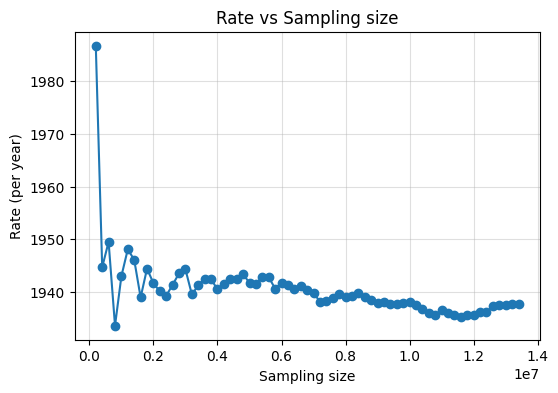

In [31]:
# getting data from json
meta_data= get_param_from_json("ler_data/meta_unlensed_grb_low.json")

# plot the rate vs sampling size
plt.figure(figsize=(6,4))
plt.plot(meta_data['events_total'], meta_data['total_rate'], 'o-')
plt.xlabel('Sampling size')
plt.ylabel('Rate (per year)')
plt.title('Rate vs Sampling size')
plt.grid(alpha=0.4)
plt.show()

In [32]:
# select only events after sampling size of 
idx = np.where(meta_data['events_total'] > 1e7)[0]
# take average 
grb_rate_unlensed_low = np.mean(meta_data['total_rate'][idx])
print('Unlensed GRB Rate (per year) =', grb_rate_unlensed_low)

Unlensed GRB Rate (per year) = 1936.4754603985245


In [33]:
lensed_param_detectable = ler.selecting_n_lensed_detectable_events(
    size=100000,
    batch_size=200000,
    # snr_threshold=[8.0,8.0],
    # num_img=[1,1],
    resume=True,
    trim_to_size=True,
    detectability_condition="pdet",
    output_jsonfile="n_lensed_params_detectable_grb_low.json",
    meta_data_file="meta_lensed_grb_low.json",
)

collected number of detectable events =  0


100%|█████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 82.30it/s]


given detectability_condition == pdet
collected number of detectable events =  1730
total number of events =  200000
total rate (yr^-1): 1.7745358808154599


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 56.25it/s]


given detectability_condition == pdet
collected number of detectable events =  3518
total number of events =  400000
total rate (yr^-1): 1.8042824360430023


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.25it/s]


given detectability_condition == pdet
collected number of detectable events =  5235
total number of events =  600000
total rate (yr^-1): 1.7899220300710854


100%|█████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 46.37it/s]


given detectability_condition == pdet
collected number of detectable events =  6918
total number of events =  800000
total rate (yr^-1): 1.7740230091736056


100%|█████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 22.97it/s]


given detectability_condition == pdet
collected number of detectable events =  8659
total number of events =  1000000
total rate (yr^-1): 1.7763822187261349


100%|█████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 90.84it/s]


given detectability_condition == pdet
collected number of detectable events =  10389
total number of events =  1200000
total rate (yr^-1): 1.7760744957410222


 13%|██████▊                                               | 25395/200000 [00:05<00:39, 4403.26it/s]


KeyboardInterrupt: 

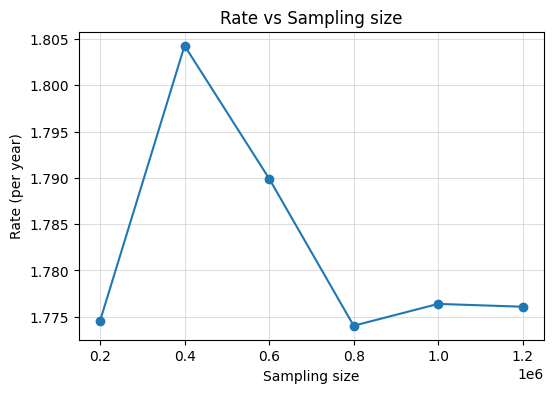

In [34]:
# getting data from json
meta_data= get_param_from_json("ler_data/meta_lensed_grb_low.json")

# plot the rate vs sampling size
plt.figure(figsize=(6,4))
plt.plot(meta_data['events_total'], meta_data['total_rate'], 'o-')
plt.xlabel('Sampling size')
plt.ylabel('Rate (per year)')
plt.title('Rate vs Sampling size')
plt.grid(alpha=0.4)
plt.show()

In [35]:
# select only events after sampling size of 
idx = np.where(meta_data['events_total'] > 0.6e6)[0]
# take average 
grb_rate_lensed_low = np.mean(meta_data['total_rate'][idx])
print('Lensed GRB Rate (per year) =', grb_rate_lensed_low)

Lensed GRB Rate (per year) = 1.7754932412135875


In [36]:
grb_rate_unlensed_low/grb_rate_lensed_low, grb_rate_unlensed_low, grb_rate_lensed_low

(1090.669012671038, 1936.4754603985245, 1.7754932412135875)

## HIGH

In [37]:
ler = LeR(
    npool=8,
    verbose=False,
    z_max=10,
    pdet_finder=grb.pdet_calculator,
    source_priors= {'merger_rate_density': 'merger_rate_density_bbh_popI_II_oguri2018'},
    source_priors_params= {'merger_rate_density': {'R0': (10.55+19.02)*1e-08, 'b2': 1.6, 'b3': 2.0, 'b4': 30}},
    event_type='BNS',
    mtot_max=51,
    psds={'L1':'../rates_o4/o4_psd.txt', 'H1':'../rates_o4/o4_psd.txt'},
    snr_type="interpolation",
)

In [41]:
unlensed_param_detectable = ler.selecting_n_unlensed_detectable_events(
    size=400000,
    batch_size=200000,
    resume=True,
    trim_to_size=False,
    detectability_condition="pdet",
    output_jsonfile="n_unlensed_params_detectable_grb_high.json",
    meta_data_file="meta_unlensed_grb_high.json",
)

removing ./ler_data/n_unlensed_params_detectable_grb_high.json and ./ler_data/meta_unlensed_grb_high.json if they exist
collected number of detectable events =  0
given detectability_condition == 'pdet'
collected number of detectable events =  4290
total number of events =  200000
total rate (yr^-1): 27473.69896589299
given detectability_condition == 'pdet'
collected number of detectable events =  8334
total number of events =  400000
total rate (yr^-1): 26685.991513024725
given detectability_condition == 'pdet'
collected number of detectable events =  12494
total number of events =  600000
total rate (yr^-1): 26671.04855321422
given detectability_condition == 'pdet'
collected number of detectable events =  16555
total number of events =  800000
total rate (yr^-1): 26505.07496389035
given detectability_condition == 'pdet'
collected number of detectable events =  20698
total number of events =  1000000
total rate (yr^-1): 26510.518470678464
given detectability_condition == 'pdet'
collec

KeyboardInterrupt: 

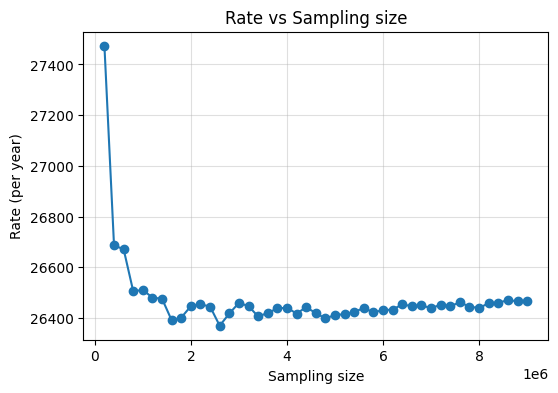

In [42]:
# getting data from json
meta_data= get_param_from_json("ler_data/meta_unlensed_grb_high.json")

# plot the rate vs sampling size
plt.figure(figsize=(6,4))
plt.plot(meta_data['events_total'], meta_data['total_rate'], 'o-')
plt.xlabel('Sampling size')
plt.ylabel('Rate (per year)')
plt.title('Rate vs Sampling size')
plt.grid(alpha=0.4)
plt.show()

In [43]:
# select only events after sampling size of 
idx = np.where(meta_data['events_total'] > 6e6)[0]
# take average 
grb_rate_unlensed_high = np.mean(meta_data['total_rate'][idx])
print('Unlensed GRB Rate (per year) =', grb_rate_unlensed_high)

Unlensed GRB Rate (per year) = 26452.31126021443


In [44]:
lensed_param_detectable = ler.selecting_n_lensed_detectable_events(
    size=100000,
    batch_size=200000,
    # snr_threshold=[8.0,8.0],
    # num_img=[1,1],
    resume=True,
    trim_to_size=True,
    detectability_condition="pdet",
    output_jsonfile="n_lensed_params_detectable_grb_high.json",
    meta_data_file="meta_lensed_grb_high.json",
)

collected number of detectable events =  0


100%|█████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 97.16it/s]


given detectability_condition == pdet
collected number of detectable events =  1695
total number of events =  200000
total rate (yr^-1): 23.801589344555182


100%|█████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 34.86it/s]


given detectability_condition == pdet
collected number of detectable events =  3427
total number of events =  400000
total rate (yr^-1): 24.061370703183073


100%|████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 101.85it/s]


given detectability_condition == pdet
collected number of detectable events =  5155
total number of events =  600000
total rate (yr^-1): 24.129241508590354


100%|█████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 80.13it/s]


given detectability_condition == pdet
collected number of detectable events =  6881
total number of events =  800000
total rate (yr^-1): 24.156155793493244


100%|█████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 89.82it/s]


given detectability_condition == pdet
collected number of detectable events =  8603
total number of events =  1000000
total rate (yr^-1): 24.161070575953776


  1%|▊                                                      | 2796/200000 [00:00<00:53, 3670.81it/s]


KeyboardInterrupt: 

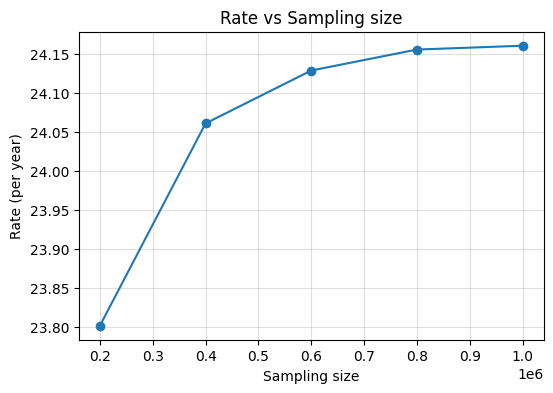

In [45]:
# getting data from json
meta_data= get_param_from_json("ler_data/meta_lensed_grb_high.json")

# plot the rate vs sampling size
plt.figure(figsize=(6,4))
plt.plot(meta_data['events_total'], meta_data['total_rate'], 'o-')
plt.xlabel('Sampling size')
plt.ylabel('Rate (per year)')
plt.title('Rate vs Sampling size')
plt.grid(alpha=0.4)
plt.show()

In [46]:
# select only events after sampling size of 
idx = np.where(meta_data['events_total'] > 0.6e6)[0]
# take average 
grb_rate_lensed_high = np.mean(meta_data['total_rate'][idx])
print('Lensed GRB Rate (per year) =', grb_rate_lensed_high)

Lensed GRB Rate (per year) = 24.15861318472351


In [47]:
grb_rate_unlensed_high/grb_rate_lensed_high, grb_rate_unlensed_high, grb_rate_lensed_high

(1094.9432841178698, 26452.31126021443, 24.15861318472351)